In [18]:
%run master_functions.ipynb

In [68]:
def load_parameters(solutes, nclusters, linkage='ward'):

    params = {i : {} for i in solutes}
    
    for n, s in zip(nclusters, solutes):
        
        if s != 'GCL':
            ihmm = file_rw.load_object('saved_parameters/2000iter_%s_unseeded.pl' % s)['ihmm']
        else:
            ihmm = file_rw.load_object('saved_parameters/2000iter_%s.pl' % s)['ihmm']

        A, sigma, mu, T, mu_weights = organize_parameters(ihmm) # arrange parameters into arrays suitable for clustering
        
        params[s]['z'] = file_rw.load_object('clusters_%s_%s.pl' %(s, linkage))[0][n]['z']
        params[s]['final_parameters'] = file_rw.load_object('clusters_%s_%s.pl' %(s, linkage))[0][n]
        
        params[s]['unclustered_params'] = {'A': A, 'sigma': sigma, 'mu': mu, 'T': T, 'mu_weights': mu_weights}
        
        params[s]['density'] = get_density(s)
        params[s]['coord'] = get_coordination(s)
        params[s]['hbonded'], params[s]['monomer_hbonds'], params[s]['definitions'] = get_hbonds(s)
        
    return params

In [69]:
solutes = ['MET', 'GCL', 'URE', 'ACH']
nclusters = [10, 10, 10, 10]

params = load_parameters(solutes, nclusters)

In [38]:
def hbonded_associated(residues, params, bar_width=0.75, bar_cmap = plt.cm.cool, savename=None):
    
    fig, haax = plt.subplots()
    names = {'MET': 'methanol', 'URE': 'urea', 'GCL': 'ethylene\n glycol', 'ACH': 'acetic\n acid'}
    
    for i, r in enumerate(residues):
    
        z = params[r]['z']
        hbonded = params[r]['hbonded']
        coordinated = params[r]['coord']
        nsolute = hbonded.shape[0]
        
        nclusters = np.unique(z).size
        interactions = np.zeros([nclusters, 3])  # [hbonded, both, associated]

        both = 0
        only_hbonded = 0
        only_coord = 0

        for t in range(nsolute):
            
            zipped = np.array([hbonded[t, :], coordinated[t, :]]).astype(bool)

            both += len(np.where(zipped.sum(axis=0) == 2)[0])

            not_both_ndx = np.where(zipped.sum(axis=0) < 2)[0]
            only_hbonded += len(np.where(zipped[0, not_both_ndx])[0])
            only_coord += len(np.where(zipped[1, not_both_ndx])[0])

            for s in range(np.unique(z).size):

                ndx = np.where(z[t, :] == s)[0]

                data = zipped[:, ndx]

                not_both = np.where(data.sum(axis=0) < 2)[0]

                interactions[s, 1] += len(np.where(data.sum(axis=0) == 2)[0])
                interactions[s, 0] += len(np.where(data[0, not_both])[0])
                interactions[s, 2] += len(np.where(data[1, not_both])[0])

        bar_colors = np.array([bar_cmap(j) for j in np.linspace(50, 250, 4).astype(int)])

        tot = z.size
        both /= tot
        only_hbonded /= tot
        only_coord /= tot

        #msd = file_rw.load_object('trajectories/%s_msd.pl' % res)

        haax.bar(i, only_hbonded, bar_width, color=bar_colors[0], edgecolor='white', linewidth=1)
        haax.bar(i, both, bar_width, bottom=only_hbonded, color=bar_colors[1], edgecolor='white', linewidth=1)
        haax.bar(i, only_coord, bar_width, bottom=only_hbonded + both, color=bar_colors[2], edgecolor='white', linewidth=1)
        #msdax.bar(i + bar_width/2, msd.MSD.mean(axis=1)[2000], bar_width, color=bar_colors[3], edgecolor='white', lw=2)

    haax.tick_params(labelsize=14)
    haax.set_xticks([0, 1, 2, 3])
    haax.set_xticklabels([names[res] for res in residues])
    haax.set_ylabel('Fraction of time spent interacting', fontsize=14)
    haax.set_ylim(0, 1)

#     msdax.tick_params(labelsize=14)
#     msdax.set_ylim(0, 4.5)
#     msdax.set_ylabel('Mean Squared Displacement', fontsize=14)

    hatches = []
    labels = ['Hbonded', 'Both', 'Associated']
    for i in range(3):
        hatches.append(mpatches.Patch(facecolor=bar_colors[i], label=labels[i], edgecolor='white'))

    fig.legend(handles=hatches, fontsize=14, ncol=3, loc='upper left', bbox_to_anchor=(0.15, 0.94), 
               columnspacing=0.9, frameon=False)
    fig.tight_layout()
    
    if savename is not None:
        
        fig.savefig(savename)


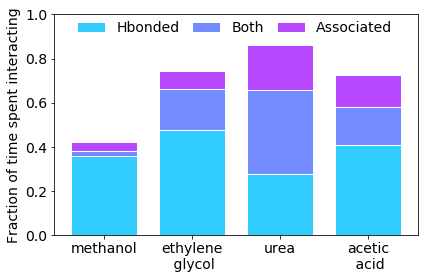

In [41]:
save = True

if save:
    savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/figures/hbonds_assoc_summary.pdf'
else:
    savename = None

hbonded_associated(solutes, params, bar_width=0.75, bar_cmap=plt.cm.cool, savename=savename)

In [65]:
def rdf(residues, params, cmap=plt.cm.jet, savename=None):
    
    colors = np.array([cmap(i) for i in np.linspace(50, 225, len(residues)).astype(int)])
    names = {'MET': 'methanol', 'URE': 'urea', 'GCL': 'ethylene glycol', 'ACH': 'acetic acid'}
    
    fig, rdfax = plt.subplots(len(residues), 1, sharex=True, gridspec_kw = {'wspace':0, 'hspace':0})
    
    for i, r in enumerate(residues):
        
        z = params[r]['z']
        mu = params[r]['unclustered_params']['mu']
        mu_weights = params[r]['unclustered_params']['mu_weights']

        mur = np.linalg.norm(mu[:2, :], axis=0)
        rdf = []
        for j, m in enumerate(mur):
            rdf += [m] * mu_weights[j]
            
        nbins = 15
        n, edges = np.histogram(rdf, range=(0, 3), bins=15, density=True)
        x = np.zeros([2 * nbins + 2])
        y = np.zeros_like(x)
        x[1::2] = edges
        x[2::2] = edges[:-1]
        x += edges[1] - edges[0]
        y[:-2:2] = n
        y[1:-1:2] = n
        rdfax[i].plot(x, y, color=colors[i], lw=2)
        rdfax[i].hist(rdf, bins=15, range=(0, 3), color=colors[i], density=True, alpha=0.7)
        rdfax[i].set_ylim(0, 2)
        rdfax[i].set_yticks([1, 2])
        rdfax[i].tick_params(labelsize=14)
        hatch = mpatches.Patch(facecolor='xkcd:white', label=names[r], edgecolor='white')
        rdfax[i].legend(handles = [hatch], loc='upper right', frameon=False, fontsize=14)

    
    rdfax[2].set_ylabel('          Cluster frequency', fontsize=14)
    rdfax[3].set_xlabel('Radial distance from nearest pore center (nm)', fontsize=14)
    fig.tight_layout()
    
    if savename is not None:
        fig.savefig(savename)



/home/ben/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


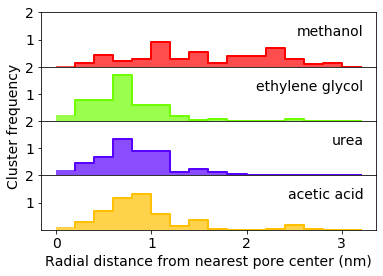

In [132]:
save = True

if save:
    savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/figures/rdf_summary.pdf'
else:
    savename = None
    
rdf(solutes, params, savename=savename, cmap=plt.cm.prism)

In [135]:
def dwell_time_comparison(residues, params, cmap=plt.cm.jet, savename=None, dt=0.5, bar_width=0.4):
    
    colors = np.array([cmap(i) for i in np.linspace(50, 225, len(residues)).astype(int)])
    
    names = {'MET': 'methanol', 'URE': 'urea', 'GCL': 'ethylene glycol', 'ACH': 'acetic acid'}
    
    fig, ax = plt.subplots()
    
    for i, r in enumerate(residues):
        
        T = params[r]['final_parameters']['T']
        z = params[r]['z']
        
        prevelant_states, state_counts = prevalent_states(z, percent=50)  # states that are at least half of trajectories
        
        max_selfT_ndx = prevelant_states[np.argmax(np.diag(T.mean(axis=0))[prevelant_states])]
        max_selfT = T[:, max_selfT_ndx, max_selfT_ndx]
        
        dwells = dt / (1 - max_selfT)
                
        ax.barh(i, dwells, bar_width, color=colors[i], xerr=dwells.std())
    
    ax.set_yticks([0, 1, 2, 3])
    ax.set_yticklabels([names[r] for r in residues])
    ax.invert_yaxis()
    ax.set_xlabel('Largest expected dwell time (ns)', fontsize=14)
    ax.tick_params(labelsize=14)
    #fig.legend(handles=[hatch1, hatch2], fontsize=14, loc='lower left', bbox_to_anchor=(0.38, 0.15))
    
    fig.tight_layout()
    
    if savename is not None:
        fig.savefig(savename)
        
    plt.show()
    

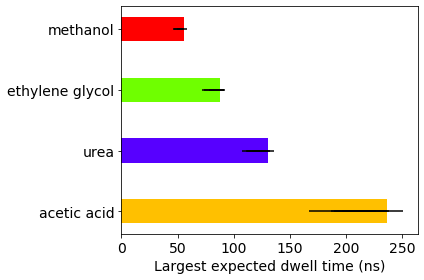

In [136]:
save = True

if save:
    savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/figures/dwell_time_summary.pdf'
else:
    savename = None
    
dwell_time_comparison(solutes, params, savename=savename, cmap=plt.cm.prism)